# 動的時間伸縮法 (Dynamic Time Warping, DTW)

動的時間伸縮法 (Dynamic Time Warping, DTW)は二つの系列データの距離（非類似度）尺度です．長さが違う系列データペアに対応した距離尺度であり，派生手法もたくさん発表されています．

二つの系列データが同じ系列長でない場合は単純に同じ地点同士の距離を計算するだけでは系列同士の距離を求めることはできません．そのために，二つの系列データのどことどこの距離を計算すればいいのかを決める必要があります．これを __アライメント（alignment）__，または __ワーピングパス（warping path）__ と呼びます．

> ![](https://rtavenar.github.io/blog/fig/dtw_vs_euc.svg)
> ![](https://rtavenar.github.io/blog/fig/dtw_path_matrix.svg)
> 
> 出典：[An introduction to Dynamic Time Warping | Romain Tavenard](https://rtavenar.github.io/blog/dtw.html )

::::{admonition} DTWの計算方法
:class: note


1. 2 つの時系列の各点の距離(データの次元にもよるが、今回は絶対値)を計算した(コスト)行列を作成

$$
\begin{aligned}
& \text { time series } T: t_0, t_1, \ldots, t_N, \\
& \text { time series } S: s_0, s_1, \ldots, s_M \text {, } \\
& \boldsymbol{W}:=(\delta(i, j)) \\
& \text { where } \delta\left(t_i, s_j\right):=\left|t_i-s_j\right|, i \in\{0,1, \ldots, N\}, j \in\{0,1, \ldots, M\} \\
&
\end{aligned}
$$

2. この行列上を $(0,0)$ から $(\mathrm{N}, \mathrm{M})$ を通るパスで単調性増加性を満たすものを考える。

$$
\begin{array}{r}
\text { path } \tau: \tau(0)=(0,0), \tau(1), \ldots, \tau(p)=\left(p_i, p_j\right), \ldots, \tau(K), \\
\text { where } p_i \in\{0,1, \ldots, N\}, p_j \in\{0,1, \ldots, M\} .
\end{array}
$$

　　　　特に、このpath $\tau$ で単調性増加性を満たすようなものを考える。

$$
\tau(p) \leq \tau(q) \Longleftrightarrow{ }^{\text {def }} p_i \leq q_i \text { or } p_j \leq q_j \text {. if } p \leq q \text {, then } \tau(p) \leq \tau(q) .
$$

3. この pathが通る行列 $\boldsymbol{W}$ の要素の和で最少となる値をDTWのコストとする。

$$
\begin{aligned}
\operatorname{cost}(\tau) & :=\sum_p \delta\left(p_i, p_j\right) \\
\operatorname{Dist}(T, S) & :=\min _\tau \operatorname{cost}(\tau)
\end{aligned}
$$

> 引用：[時系列データを比較する方法-Derivative DTW, DTW- #Python - Qiita | @tee_shizuoka](https://qiita.com/tee_shizuoka/items/2ac9e6eda39664ca8345)

::::

::::{admonition} 疑似コード
:class: note

このDTWについてはWikipediaにわかりやすい疑似コードが載っています．

```c
int DTWDistance(s: array [1..n], t: array [1..m]) {
    DTW := array [0..n, 0..m]
    
    for i := 0 to n
        for j := 0 to m
            DTW[i, j] := infinity
    DTW[0, 0] := 0
    
    for i := 1 to n
        for j := 1 to m
            cost := d(s[i], t[j])
            DTW[i, j] := cost + minimum(DTW[i-1, j  ],    // insertion
                                        DTW[i  , j-1],    // deletion
                                        DTW[i-1, j-1])    // match
    
    return DTW[n, m]
}
```
> 出典：[Dynamic time warping - Wikipedia](https://en.wikipedia.org/wiki/Dynamic_time_warping)

::::

今回はこれをPythonで実装してみましょう．

## パッケージのimport

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib_fontja
import seaborn as sns

## サンプルデータ系列の作成

DTWは二つの系列データの系列長（長さ）が同じでない場合でも計算することができるので，ここでは別々の長さの系列データを適当に作成します．

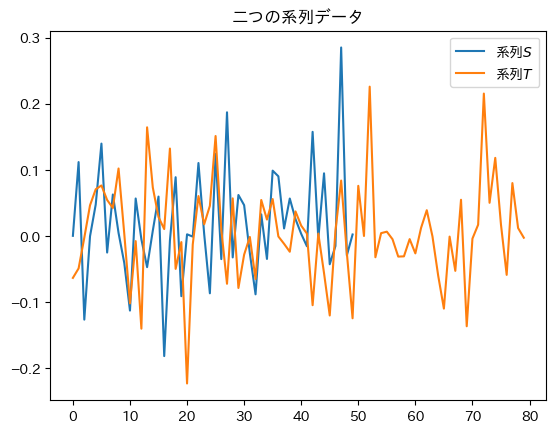

In [8]:
SEED = 2024_05_22
rng = np.random.default_rng(SEED)
len_S = 50
S = rng.normal(0,0.1,len_S) * np.sin(np.linspace(0,100, len_S)) 
len_T = 80
T = rng.normal(0,0.1,len_T) * np.cos(np.linspace(0,100, len_T))

plt.title("二つの系列データ")
plt.plot(np.arange(S.size), S, label="系列$S$")
plt.plot(np.arange(T.size), T, label="系列$T$")
plt.legend()
plt.show()

## 距離行列の作成

DTWでは二つの系列データの任意の二点間の距離を計算するために，好きな距離関数を利用することが可能です．ここでは誤差の絶対値を利用することにします．  
系列$S$と系列$T$のそれぞれ任意の地点$s_i$と$t_j$の間の距離を以下の式で求めます．

$$
D(s_i,t_j) = |s_i-t_j|
$$

これをPythonで実装します．ここで注意したいのは，$S$も$T$も一次元配列であり，全てのペアに対して距離を求めたいということです．これをfor文で書くことはもちろん可能ですが，Pythonではfor文は極力書かない方が速度的に良いとされています．そのため，NumPyを使って一行で書いてみます．

In [9]:
distance = lambda seq1,seq2: np.abs(seq1[:,None] - seq2[None,:])

print(D:=distance(S,T))
print(D.shape)

[[0.06366165 0.04932427 0.00278626 ... 0.07983255 0.01176223 0.00286044]
 [0.1752891  0.16095172 0.11441371 ... 0.0317949  0.09986522 0.11448789]
 [0.06316494 0.07750232 0.12404033 ... 0.20665914 0.13858882 0.12396615]
 ...
 [0.34873005 0.33439267 0.28785466 ... 0.20523585 0.27330617 0.28792884]
 [0.03413731 0.01979993 0.02673809 ... 0.10935689 0.04128657 0.02666391]
 [0.06568638 0.051349   0.00481099 ... 0.07780782 0.0097375  0.00488517]]
(50, 80)


## コスト行列の作成とDTW距離

DTWでは，最終的に二つの系列の距離を求めます．この過程で$(s_0, t_0)$を始点，$(s_{|S|},t_{|T|})$を終点に，この二点をつなげるコストの低いパスを見つけます．このコストを作成する関数を作成しましょう．

::::{admonition} コスト行列作成のための前提条件
:class: note

- cost行列は$|S|\times|T|$の行列になります．
- cost行列の各要素は，__値が小さい方が良い__ ので，初期化の際には inf で埋めます．
- ある地点のcostを求めるには，周辺の（自分より若いindexを持つ）要素を参照することに注意が必要です．
- 「終点のコスト」はDTWにおいて系列$S$と$T$の距離を表します．

::::

In [10]:
def dtw(x,y, distance=distance):
    # initialization
    D = distance(x,y)
    cost = np.full_like(D,np.inf)
    cost[0,0] = D[0,0]
    # udpate dtw cost matrix
    for i in range(x.size):
        for j in range(y.size):
            if i == j == 0:
                continue
            _window = cost[i-1, j], cost[i,j-1], cost[i-1,j-1]
            cost[i,j] = D[i,j] + np.min(_window)
    return cost[-1,-1],cost

dtw_score, cost = dtw(S,T)

print(dtw_score)
print(cost)

3.3086055971097115
[[0.06366165 0.11298592 0.11577218 ... 4.27986265 4.29162488 4.29448532]
 [0.23895075 0.22461337 0.22739963 ... 4.20949171 4.30935694 4.40611277]
 [0.30211569 0.30211569 0.3486537  ... 4.2813787  4.34808053 4.43332309]
 ...
 [3.51312953 3.59099378 3.07635315 ... 3.26243385 3.39803999 3.43980682]
 [3.47394413 3.49374406 3.10309123 ... 3.37179075 3.30372043 3.33038433]
 [3.39607071 3.44741972 3.10790223 ... 3.39246199 3.31345792 3.3086056 ]]


### この関数の細かい説明

距離行列を作成します．
```python
def dtw(x,y, distance=distance):
    # initialization
    D = distance(x,y)
```

cost行列は$|S|\times|T|$の行列になります．
cost行列の各要素は，__値が小さい方が良い__ ので，初期化の際には inf で埋めます．  
また，始点は「これまでの経路」が存在しないので，$d(s_0, t_0)$をそのまま利用します．

```py
    cost = np.full_like(D,np.inf)
    cost[0,0] = D[0,0]
```

始点以外のコスト行列を更新するために，系列$S$と$T$の全ての要素を舐めるための二重ループを行います．ただし，始点（$i=0$かつ$j=0$）の場合は既にコストが代入されているので，`continue`でこのステップ（jについてのループの内部で行う処理）を飛ばします．

```py
    # udpate dtw cost matrix
    for i in range(x.size):
        for j in range(y.size):
            if i == 0 and j == 0:
                continue
```

今見ている$i,j$について，コストを更新します．そのために，コスト計算に必要な要素をまとめて（`_window`にタプルとしてまとめて代入しています），この中の最小値を計算します．  
また，$i,j$に対応する距離を取り出します．この二つの値を足すことで，$i,j$に対応するコストが求まります．最後は終点のコストと，ここまでで作成したコスト行列を返して終了です．

```py
            _window = cost[i-1, j], cost[i,j-1], cost[i-1,j-1]
            cost[i,j] = D[i,j] + np.min(_window)
    return cost[-1,-1],cost
```
このプログラムだと条件分けしていないので，continue後の初回にcost[-1,1],cost[0,0],cost[-1,0]を探索することになってしまいます．costは今見ている$(i,j)$地点以前の近傍をもとに計算するはずなので，このプログラムは不必要な所の値をチェックしていることになります．しかし，これら三つのコストは初期状態では必ずinfを持っているので，問題はありません．


「終点のコスト」はDTWにおいて系列$S$と$T$の距離を表します．

## 波形同士のアライメント（warping path）

ここで作成したコスト行列から，$(0,0)$地点から$(|S|,|T|)$地点までの最短経路を見つけることができます．

::::{admonition} 最短経路を見つけるためのルール
:class: note


1. $(i,j)$は$(0,0)$からスタートします．
2. $(i,j)$から次の場所に移動する場所は$(i+1,j)$，$(i,j+1)$，$(i+1,j+1)$の3点の内でコストが最小のものにします．

::::

このルールに従って見つけた最短経路を，heatmapにしてみました．

<Axes: >

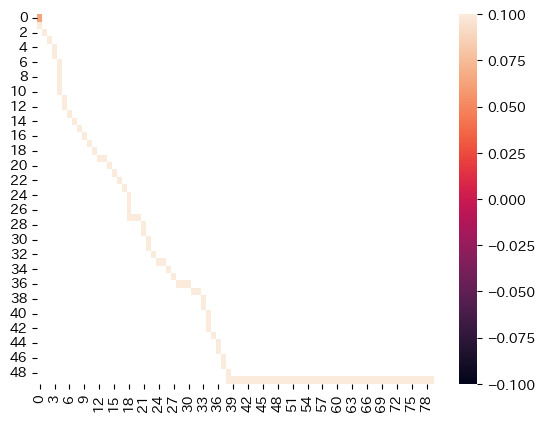

In [11]:
def get_path(C):
    # update path matrix
    path = np.zeros_like(C)+np.inf
    path[0,0] = C[0,0]
    s_size,t_size = C.shape
    i,j = 0,0
    while (i<C.shape[0]-1) and (j < C.shape[1]-1):
        _window = C[i:i+2,j:j+2]
        next = _window.argsort(axis=None)[1]
        _cost = np.sort(_window.ravel())[1]
        if next == 1:
            i += 1
        elif next == 2:
            j += 1
        else:
            i += 1
            j += 1
        path[i,j] = _cost
        # breaking
        if i == s_size-1 and j ==t_size-1:
            break
        if i ==s_size-1:
            path[i, j:] = C[i,j:]
        if j ==t_size-1:
            path[i:, j] = C[i:,j]
    return path

path = get_path(cost)
sns.heatmap(path)

ここまで「最短経路」と呼んでいたものは，波形同士のアライメント（warping path）が描く経路のことです．


> アライメントもしくはアラインメント（英: alignment）は、並べる、整列、比較などの意味。転じて以下の意味で使用する。
>
> 引用：[アライメント - Wikipedia](https://ja.wikipedia.org/wiki/%E3%82%A2%E3%83%A9%E3%82%A4%E3%83%A1%E3%83%B3%E3%83%88)


二つの系列データが同じ系列長でない場合は単純に同じ地点同士の距離を計算するだけでは系列同士の距離を求めることはできませんでした．そのために，二つの系列データのどことどこの距離を計算すればいいのかを決める必要がありました．これがここでアライメントと呼ばれているものです．

## プログラムの全体像

<Axes: >

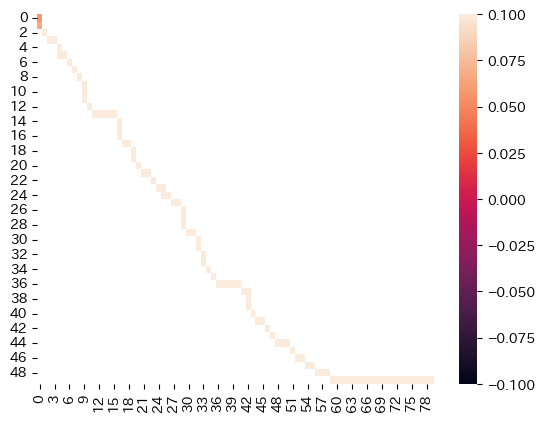

In [13]:
def dtw(x,y, distance=distance):
    D = distance(x,y)
    # initialization
    cost = np.zeros_like(D)+np.inf
    cost[0,0] = D[0,0]
    # udpate dtw cost matrix
    for i in range(x.size):
        for j in range(y.size):
            if i == 0 and j == 0:
                continue
            _window = cost[i-1, j], cost[i,j-1], cost[i-1,j-1]
            cost[i,j] = D[i,j] + np.min(_window)
    return cost[-1,-1],cost

def get_path(C):
    # update path matrix
    path = np.zeros_like(C)+np.inf
    path[0,0] = C[0,0]
    s_size,t_size = C.shape
    i,j = 0,0
    while (i<C.shape[0]-1) and (j < C.shape[1]-1):
        _window = C[i:i+2,j:j+2]
        next = _window.argsort(axis=None)[1]
        _cost = np.sort(_window.ravel())[1]
        if next == 1:
            i += 1
        elif next == 2:
            j += 1
        else:
            i += 1
            j += 1
        path[i,j] = _cost
        # breaking
        if i == s_size-1 and j ==t_size-1:
            break
        if i ==s_size-1:
            path[i, j:] = C[i,j:]
        if j ==t_size-1:
            path[i:, j] = C[i:,j]
    return path

# 適当な系列データを二つ用意
SEED = 2024_05_22_2
rng = np.random.default_rng(SEED)
len_S = 50
len_T = 80
S = rng.normal(0,0.1,len_S) * np.sin(np.linspace(0,100, len_S)) 
T = rng.normal(0,0.1,len_T) * np.cos(np.linspace(0,100, len_T))

# DTWの計算
dtw_score, cost = dtw(S,T)

# 最短経路を表示
path = get_path(cost)
sns.heatmap(path)



## 参考文献

1. [Dynamic Time Warping（動的時間伸縮法）- haripo.com](https://haripo.com/articles/2017/dynamic-time-warping )
2. [Go言語で動的時間伸縮法(Dynamic-Time-Warping)を実装しpython3から呼び出せるようにした #Python3 - Qiita](https://qiita.com/KaijiS/items/13ffda7f2490ed879e52)
3. [Dynamic time warping - Wikipedia](https://en.wikipedia.org/wiki/Dynamic_time_warping)
4. [アライメント - Wikipedia](https://ja.wikipedia.org/wiki/%E3%82%A2%E3%83%A9%E3%82%A4%E3%83%A1%E3%83%B3%E3%83%88)
5. [時系列データを比較する方法-Derivative DTW, DTW- #Python - Qiita | @tee_shizuoka](https://qiita.com/tee_shizuoka/items/2ac9e6eda39664ca8345)
6. [DTWで長さの違う波形を比較しよう！ - YouTube](https://www.youtube.com/watch?v=7sWtbayTUA0&ab_channel=K_DM%E3%80%90%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92xPython%E3%80%91)
7. [An introduction to Dynamic Time Warping](https://rtavenar.github.io/blog/dtw.html)